<a href="https://colab.research.google.com/github/JocelynWSJ/ML-Amazon-Fine-Food-Reviews/blob/main/cis519_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Part0 - Setting

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')
%cd /content/drive/Shareddrives/cis519_project

Mounted at /content/drive
/content/drive/Shareddrives/cis519_project


In [ ]:
import numpy as np
import pandas as pd
!pip3 install pandasql
import pandasql as ps
import tensorflow as tf
from tensorflow import keras
import re
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

  Created wheel for pandasql: filename=pandasql-0.7.3-cp37-none-any.whl size=26820 sha256=0a87a0c2e161ee001c0b5f7766853903f2786b76c03749c9842a8fe782537bff
  Stored in directory: /root/.cache/pip/wheels/53/6c/18/b87a2e5fa8a82e9c026311de56210b8d1c01846e18a9607fc9
Successfully built pandasql


#Part1-Operations on 'Summary' column

## 1.1 Logistic regression

In [ ]:
# Read in the csv file
df = pd.read_csv('Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
# show the summary column
df_summary = df[['Summary']]
df_summary

,Summary
0,Good Quality Dog Food
1,Not as Advertised
2,"""Delight"" says it all"
3,Cough Medicine
4,Great taffy
...,...
568449,Will not do without
568450,disappointed
568451,Perfect for our maltipoo
568452,Favorite Training and reward treat


### Predicting Score with Raw Data

In [ ]:
from sklearn.model_selection import train_test_split

df.dropna(inplace=True)
X_train, X_test, y_train, y_test = train_test_split(df['Summary'], df['Score'], random_state = 42)
print('X_train first entry:', X_train[0])
print('X_train shape:', X_train.shape)

X_train first entry: Good Quality Dog Food
X_train shape: (426308,)


In [ ]:
# Using CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

vect = CountVectorizer().fit(X_train)
clf_SGD = SGDClassifier(loss='log', max_iter=10000, random_state=42)
X_train_vectorized = vect.transform(X_train)
clf_SGD.fit(X_train_vectorized, y_train)
train_pred = clf_SGD.predict(X_train_vectorized)
test_pred = clf_SGD.predict(vect.transform(X_test))
train_acc = accuracy_score(train_pred, y_train)
test_acc = accuracy_score(test_pred, y_test)
f1 = f1_score(test_pred, y_test, average='weighted')

print('train accuracy:', round(train_acc, 3))
print('test accuracy:', round(test_acc, 3))
print('f1 score:', round(f1,3))


train accuracy: 0.701
test accuracy: 0.701
f1 score: 0.768


### Predicting Score with Created Word Dictionary

In [ ]:
import string
import tensorflow_datasets as tfds
def labeler(example, index):
  return example, tf.cast(index, tf.int64)  

def delete_punc(x):
  punctuation_string = string.punctuation
  for s in punctuation_string:
    x = x.replace(s,'')
  return x

def prepare(x):
  x = str(x)
  x = x.split()
  x = [s.strip() for s in x]
  x = [s.lower() for s in x]
  x = map(lambda te: delete_punc(te),x)
  return list(x)

df_summary = df_summary[:100000]
save = []

a = df_summary['Summary'].apply(prepare)
for i in range(len(a)):
    save.extend(a[i])
save = list(set(save))

for item in save: 
  if len(item)<= 1:
    save.remove(item)
#Create two dictionaries 
# index: word
word_index = {k:v for k,v in enumerate(save)}
# word: index
number_index = dict([(value, key) for (key, value) in word_index.items()])

In [ ]:
#Convert the word into numbers
#input total_save
total_save = []
df_summary = df_summary[:100000]
temdf = df_summary['Summary'].apply(prepare)
temdf
for i in (range(len(temdf))):
  # print(i)
  index_save = []
  for item in temdf[i]:
    if len(item)>1:
      # print(number_index[item])
      index_save.append(number_index[item])
  total_save.append(index_save)

In [ ]:
# input
train_data = total_save
# output
y_label = np.array(df['Score'])
y_label = y_label[:100000]

In [ ]:
from tensorflow import keras

train_data = total_save[:90000]
test_data = total_save[90000:]

train_label = y_label[:90000]
test_label = y_label[90000:]

train_data = keras.preprocessing.sequence.pad_sequences(train_data,padding='post',maxlen = 32)
test_data = keras.preprocessing.sequence.pad_sequences(test_data,padding='post',maxlen=32)

X_train = train_data
y_train = train_label
X_test = test_data
y_test = test_label

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

clf_SGD = SGDClassifier(loss='log', max_iter=10000, random_state=42)
clf_SGD.fit(X_train, y_train)
train_pred = clf_SGD.predict(X_train)
test_pred = clf_SGD.predict(X_test)
train_acc = accuracy_score(train_pred, y_train)
test_acc = accuracy_score(test_pred, y_test)
f1 = f1_score(test_pred, y_test, average='weighted')

print('train accuracy:', round(train_acc, 3))
print('test accuracy:', round(test_acc, 3))
print('f1 score:', round(f1,3))

train accuracy: 0.603
test accuracy: 0.618
f1 score: 0.74


### Predicting Positivity with Clean Summary

In [ ]:
# create a column(Positivity) based on the score 
df.dropna(inplace=True)
df[df['Score'] != 3]
df['Positivity'] = np.where(df['Score'] > 3, 1, 0)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Positivity
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1


In [ ]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
  ## clean (convert to lowercase and remove punctuations and  
  ## characters and then strip)
  text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
          
  ## Tokenize (convert from string to list)
  lst_text = text.split()    ## remove Stopwords
  if lst_stopwords is not None:
      lst_text = [word for word in lst_text if word not in
                  lst_stopwords]
  ## Stemming (remove -ing, -ly, ...)
  if flg_stemm == True:
      ps = nltk.stem.porter.PorterStemmer()
      lst_text = [ps.stem(word) for word in lst_text]
              
  ## Lemmatisation (convert the word into root word)
  if flg_lemm == True:
      lem = nltk.stem.wordnet.WordNetLemmatizer()
      lst_text = [lem.lemmatize(word) for word in lst_text]
          
  ## back to string from list
  text = " ".join(lst_text)
  return text

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
lst_stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
import re
df["Summary_clean"] = df["Summary"].apply(lambda x:
utils_preprocess_text(x, flg_stemm=False, flg_lemm=True,
lst_stopwords=lst_stopwords))
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Positivity,Summary_clean
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,good quality dog food
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,advertised
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1,delight say
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0,cough medicine
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1,great taffy


In [ ]:
from sklearn import feature_extraction, model_selection
data_train,data_test = model_selection.train_test_split(df,test_size = 0.3)

X_train = data_train['Summary_clean']
X_test = data_test['Summary_clean']
y_train = data_train['Positivity']
y_test = data_test['Positivity']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer().fit(X_train)

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

clf_SGD = SGDClassifier(loss='log', max_iter=10000, random_state=42)
X_train_vectorized = vect.transform(X_train)
clf_SGD.fit(X_train_vectorized, y_train)
train_pred = clf_SGD.predict(X_train_vectorized)
test_pred = clf_SGD.predict(vect.transform(X_test))
train_acc = accuracy_score(train_pred, y_train)
test_acc = accuracy_score(test_pred, y_test)
f1 = f1_score(test_pred, y_test, average='weighted')

print('train accuracy:', round(train_acc, 3))
print('test accuracy:', round(test_acc, 3))
print('f1 score:', round(f1,3))

train accuracy: 0.856
test accuracy: 0.853
f1 score: 0.872


## 1.2 - Linear Regression

### Predict score with Summary_clean

In [ ]:
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing## for explainer

vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))
X = df['Summary_clean']
#X = df['text_clean']
vectorizer.fit(X)
X_matrix = vectorizer.transform(X)
# dic_vocabulary = vectorizer.vocabulary_
X_matrix.shape

(568411, 10000)

In [ ]:
# Split the data into training/testing sets
X_train = X_matrix[:-170000]
X_test = X_matrix[-170000:]

# Split the targets into training/testing sets
y_train = df['Score'][:-170000]
y_test = df['Score'][-170000:]

print('df shape:', df.shape)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

df shape: (568411, 12)
X_train shape: (398411, 10000)
X_test shape: (170000, 10000)
y_train shape: (398411,)
y_test shape: (170000,)


In [ ]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_pred = regr.predict(X_test)
print(y_pred)

[5.4317579  3.98548067 4.84396331 ... 4.7058944  5.41802951 4.84908135]


In [ ]:
from sklearn.metrics import mean_squared_error,accuracy_score
y_test = np.array(y_test).astype(float)
y_pred = np.array(y_pred).astype(float)

mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)

from sklearn import metrics
r2 = r2_score(y_test, y_pred)
print("r2: ", r2)

y_test = list(y_test)
y_pred = list(y_pred)

MSE:  0.8956631962415149
r2:  0.47134965377201943


### Predict score with new stop word list

In [ ]:
stopwords_new = stopwords.words("english")

remove_list = ['ain','aren',"aren't",'couldn',"couldn't",'didn',"didn't",'doesn',"doesn't",'hadn',"hadn't",'hasn',"hasn't",'haven',"haven't",
               'isn',"isn't",'ma','mightn',"mightn't",'mustn',"mustn't",'needn',"needn't",'shan',"shan't",'shouldn',"shouldn't",'wasn',"wasn't",
               'weren',"weren't",'won',"won't",'wouldn',"wouldn't",'against','no','nor','not','don', "don't",'t','s','y','o','d','m']

for delItem in remove_list:
  stopwords_new.remove(delItem)
stopwords_new

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 

In [ ]:
df["Summary_clean_new"] = df["Summary"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=stopwords_new))
df_clean = df[["Summary","Summary_clean","Summary_clean_new"]]
df_clean.head()

,Summary,Summary_clean,Summary_clean_new
0,Good Quality Dog Food,good quality dog food,good quality dog food
1,Not as Advertised,advertised,not advertised
2,"""Delight"" says it all",delight say,delight say
3,Cough Medicine,cough medicine,cough medicine
4,Great taffy,great taffy,great taffy


In [ ]:
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing## for explainer

vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))
X = df['Summary_clean_new']
#X = df['text_clean']
vectorizer.fit(X)
X_matrix = vectorizer.transform(X)
# dic_vocabulary = vectorizer.vocabulary_
X_matrix.shape

(568411, 10000)

In [ ]:
# Split the data into training/testing sets
X_train = X_matrix[:-170000]
X_test = X_matrix[-170000:]

# Split the targets into training/testing sets
y_train = df['Score'][:-170000]
y_test = df['Score'][-170000:]

print('df shape:', df.shape)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

df shape: (568411, 13)
X_train shape: (398411, 10000)
X_test shape: (170000, 10000)
y_train shape: (398411,)
y_test shape: (170000,)


In [ ]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_pred = regr.predict(X_test)
print(y_pred)

[5.39851157 3.97827295 4.85442688 ... 4.73929285 5.50544525 4.8897335 ]


In [ ]:
y_test = np.array(y_test).astype(float)
y_pred = np.array(y_pred).astype(float)

mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)

r2 = r2_score(y_test, y_pred)
print("r2: ", r2)

y_test = list(y_test)
y_pred = list(y_pred)

MSE:  0.7806817634657832
r2:  0.5392155374007683


### Predict positivity

In [ ]:
# Split the data into training/testing sets
X_train = X_matrix[:-170000]
X_test = X_matrix[-170000:]

# Split the targets into training/testing sets
y_train = df['Positivity'][:-170000]
y_test = df['Positivity'][-170000:]

print('df shape:', df.shape)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

df shape: (568411, 13)
X_train shape: (398411, 10000)
X_test shape: (170000, 10000)
y_train shape: (398411,)
y_test shape: (170000,)


In [ ]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_pred = regr.predict(X_test)
print(y_pred)

[1.15042359 0.70466835 0.99024938 ... 0.93669791 1.16678242 1.00430004]


In [ ]:
y_test = np.array(y_test).astype(float)
y_pred = np.array(y_pred).astype(float)

mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)

r2 = r2_score(y_test, y_pred)
print("r2: ", r2)

y_pred = np.round(y_pred)
accuracy_score = accuracy_score(y_test, y_pred)
print("accuracy_score: ", accuracy_score)

MSE:  0.0833565991062954
r2:  0.5077482014439189
accuracy_score:  0.8942529411764706


# Part2 - Operations on the comment column

## 2.1 Text prepocessing

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
!pip install lime
from lime import lime_text
import gensim
import gensim.downloader as gensim_api
from tensorflow.keras import models, layers, preprocessing as kprocessing


     |████████████████████████████████| 276kB 7.9MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=7f3eed38815775f35360891ac844eb3334efc64055f5802dec886a6f7bb31b53
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
df = pd.read_csv('Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df_target = df[['Id','Score','Text']]
df_target

,Id,Score,Text
0,1,5,I have bought several of the Vitality canned d...
1,2,1,Product arrived labeled as Jumbo Salted Peanut...
2,3,4,This is a confection that has been around a fe...
3,4,2,If you are looking for the secret ingredient i...
4,5,5,Great taffy at a great price. There was a wid...
...,...,...,...
568449,568450,5,Great for sesame chicken..this is a good if no...
568450,568451,2,I'm disappointed with the flavor. The chocolat...
568451,568452,5,"These stars are small, so you can give 10-15 o..."
568452,568453,5,These are the BEST treats for training and rew...


###Check the Score Distribution

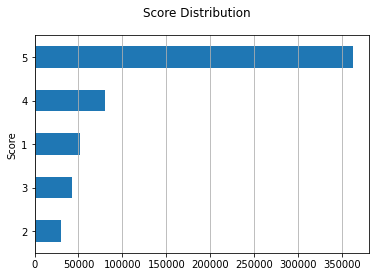

In [ ]:

fig, ax = plt.subplots()
fig.suptitle("Score Distribution")
df_target['Score'].reset_index().groupby('Score').count().sort_values(by= 
"index").plot(kind="barh", legend=False,ax=ax).grid(axis='x')
plt.show()

In [ ]:
df_target['Score'].reset_index().groupby('Score').count()

,index
Score,
1,52268
2,29769
3,42640
4,80655
5,363122


In [ ]:
#Make the distribution balanced
df_score5 = df_target[df_target['Score']==5]
df_score5 = df_score5.sample(frac = 0.08,random_state=42)
df_score4 = df_target[df_target['Score']==4]
df_score4 = df_score4.sample(frac = 0.3,random_state=42)
df_score3 = df_target[df_target['Score']==3]
df_score3 = df_score3.sample(frac = 0.5,random_state=42)
df_score2 = df_target[df_target['Score']==2]
df_score2 = df_score2.sample(frac = 0.9,random_state=42)
df_score1 = df_target[df_target['Score']==1]
df_score1 = df_score1.sample(frac = 0.55,random_state=42)

df_balanced = pd.concat([df_score5,df_score4,df_score3,df_score2,df_score1],axis=0)
df_balanced = df_balanced.sample(frac=1,random_state=42)
df_balanced


,Id,Score,Text
465223,465224,1,I love Amazon...but this product showed up wit...
4698,4699,3,The set is bigger than I thought it would be. ...
143999,144000,4,Clorets has been my favorite gum since the 80'...
298975,298976,4,Slightly richer chocolate taste over the milk ...
361440,361441,1,As a connoissuer of a wide variety of fine loo...
...,...,...,...
370885,370886,1,Item tasted plain and was crumbly. Did not tas...
245916,245917,1,"First of all, the picture that Amazon has with..."
18990,18991,5,Shipment arrived on time and in good condition...
105286,105287,5,I'm a big fan of the Blue Diamond brand almond...


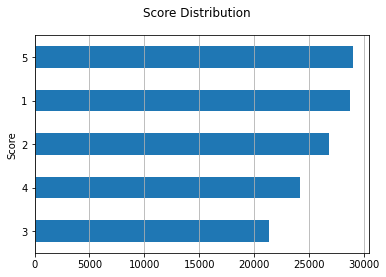

In [ ]:
#Check the Score Distribution
fig, ax = plt.subplots()
fig.suptitle("Score Distribution", fontsize=12)
df_balanced['Score'].reset_index().groupby('Score').count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [ ]:
df_target = df_balanced

### Clean Text

In [ ]:
def utils_preprocess_text(text, flg_lemm=True, lst_stopwords=None):
  '''
  Tokenize
  Stemming
  Lemmation
  '''
  text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
          
  ## Tokenize (convert from string to list)
  lst_text = text.split()    ## remove Stopwords
  if lst_stopwords is not None:
    lst_text = [word for word in lst_text if word not in
                lst_stopwords]
              
  ## convert the word into root word
  if flg_lemm == True:
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    lst_text = [lem.lemmatize(word) for word in lst_text]
        
  ## back to string from list
  text = " ".join(lst_text)
  return text

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
lst_stopwords = stopwords.words("english")
# add the 'not' words back
remove_list = ['ain','aren',"aren't",'couldn',"couldn't",'didn',"didn't",'doesn',"doesn't",'hadn',"hadn't",'hasn',"hasn't",'haven',"haven't",
               'isn',"isn't",'ma','mightn',"mightn't",'mustn',"mustn't",'needn',"needn't",'shan',"shan't",'shouldn',"shouldn't",'wasn',"wasn't",
               'weren',"weren't",'won',"won't",'wouldn',"wouldn't",'against','no','nor','not','don', "don't",'t','s','y','o','d','m']

for delItem in remove_list:
  lst_stopwords.remove(delItem)
lst_stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 

In [ ]:
lst_stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [ ]:
df_target["text_clean"] = df_target["Text"].apply(lambda x:
utils_preprocess_text(x,flg_lemm=True,
lst_stopwords=lst_stopwords))
df_target.head()

,Id,Score,Text,text_clean
465223,465224,1,I love Amazon...but this product showed up wit...,love amazonbut product showed le 2 month datin...
4698,4699,3,The set is bigger than I thought it would be. ...,set bigger thought would would take big cake s...
143999,144000,4,Clorets has been my favorite gum since the 80'...,clorets favorite gum since 80 stole piece mom ...
298975,298976,4,Slightly richer chocolate taste over the milk ...,slightly richer chocolate taste milk chocolate...
361440,361441,1,As a connoissuer of a wide variety of fine loo...,connoissuer wide variety fine loose tea sold t...


### Divide into 70% training dataset and 30% testing dataset. 

In [ ]:
data_train,data_test = model_selection.train_test_split(df_target,test_size = 0.3)

X_train = data_train['text_clean']
X_test = data_test['text_clean']
Y_train = data_train['Score']
Y_test = data_test['Score']

In [ ]:
#Implement one hot encoding on the label
from sklearn.preprocessing import OneHotEncoder
y = np.asarray(Y_train)
onehot_encoder = OneHotEncoder(sparse=False)
y_train_onehot = y.reshape(len(y), 1)
y_train_onehot = onehot_encoder.fit_transform(y_train_onehot)

y = np.asarray(Y_test)
onehot_encoder = OneHotEncoder(sparse=False)
y_test_onehot = y.reshape(len(y), 1)
y_test_onehot = onehot_encoder.fit_transform(y_test_onehot)
y_test_onehot

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

## 2.2 Tf-**Idf**
Since directly using the bag of words will make the feature matrix quite large, we plan to use term frequency–inverse document frequency (Tf-Idf) to reduce the dimensionality problem.

### Bag of words

In [ ]:
# if we directly extract the features of text_clean 
# Set the maximum number of features to be 20000
vectorizer = feature_extraction.text.CountVectorizer(max_features=20000, ngram_range=(1,2))

In [ ]:
corpus = X_train
vectorizer.fit(corpus)
X_train_trans = vectorizer.transform(X_train)
# dic_vocabulary = vectorizer.vocabulary_
X_train_trans.shape

(91073, 20000)

### Using chi-square to remove irelevant features

In [ ]:
'''
Remove the features whose p-value is less than 0.96
'''
from sklearn import feature_selection
X_try = X_train_trans
y_try = Y_train
X_names = vectorizer.get_feature_names()
p_value_limit = 0.96
df_features = pd.DataFrame()
for cat in np.unique(y_try):
    chi2, p = feature_selection.chi2(X_try, y_try==cat)
    df_features = df_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    df_features = df_features.sort_values(["y","score"], 
                    ascending=[True,False])
    df_features = df_features[df_features["score"]>p_value_limit]
X_names = df_features["feature"].unique().tolist()
len(X_names)

16381

We notice that the number of features decreased from 20,000 to 16381

### Implement Tf-Idf 

In [ ]:

# The feature was represent by the frequency how commonly they occur in some datasets 
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(X_train)


In [ ]:
print(X_train[0])

  (0, 15693)	0.2686922907443722
  (0, 13915)	0.10869201855200344
  (0, 12738)	0.19074537311420195
  (0, 10921)	0.2260722871172582
  (0, 9873)	0.12813784524308855
  (0, 8901)	0.1659179826695976
  (0, 5843)	0.1871641747522728
  (0, 5490)	0.15780456659310566
  (0, 2465)	0.3120358572222012
  (0, 2104)	0.09230203966451628
  (0, 2056)	0.17043143655910237
  (0, 1755)	0.11473823276103462
  (0, 1625)	0.13814753511180636
  (0, 1578)	0.15891577394477577
  (0, 1556)	0.13380968558759493
  (0, 1128)	0.092535829256702
  (0, 1058)	0.11839575739980847
  (0, 1043)	0.195685306765782
  (0, 1008)	0.19577765633016633
  (0, 988)	0.13955765364799735
  (0, 893)	0.24523327377870635
  (0, 844)	0.2419430743873203
  (0, 782)	0.0879827914686963
  (0, 779)	0.23821053055952363
  (0, 752)	0.18211752179114934
  (0, 706)	0.0638315226420767
  (0, 526)	0.15428986471174344
  (0, 473)	0.10146137618998233
  (0, 179)	0.16384732026185886
  (0, 134)	0.11012241511637864
  (0, 110)	0.12254242814149514
  (0, 33)	0.2365601420427902

## 2.3 Bayes’ Model

In [ ]:
classifier = naive_bayes.MultinomialNB()
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
              ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, Y_train)
## test
Y_predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

> Display the prediction results

In [ ]:
from sklearn import metrics 
classes = np.unique(Y_test)
y_test_values = pd.get_dummies(Y_test, drop_first=False).values
# Accuracy, Auc
accuracy = metrics.accuracy_score(Y_test, Y_predicted)
auc = metrics.roc_auc_score(Y_test, predicted_prob,multi_class="ovr")
print("Accuracy:", round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(Y_test, Y_predicted))

Accuracy: 0.52
Auc: 0.81
Detail:
              precision    recall  f1-score   support

           1       0.57      0.69      0.62      8701
           2       0.43      0.52      0.47      7915
           3       0.52      0.13      0.21      6426
           4       0.45      0.35      0.39      7249
           5       0.57      0.76      0.65      8741

    accuracy                           0.52     39032
   macro avg       0.51      0.49      0.47     39032
weighted avg       0.51      0.52      0.49     39032



The previous scores are not high enough, draw out the confusion matrix to find out the gap.


(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text major ticklabel objects>)

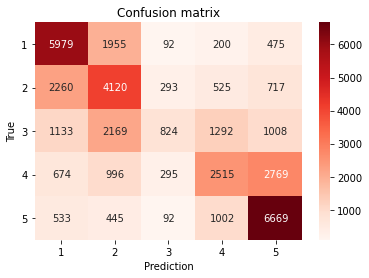

In [ ]:
# Plot confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_predicted)
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Reds)
ax.set(xlabel="Prediction", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

> Here we found that it was more difficult to distinguish between adjacent evaluations.

> Probably because there is no clear boundary between adjacent comment scores (such as 4 and 5).Also we may consider to use word embedding method to decrease the number of features. 

## 2.4 Word Embedding

In [ ]:
corpus = df_target["text_clean"]
## create list of lists of unigrams
save_corpus = []
for text in corpus:
  list_words = text.split()
  save_corpus.append(list_words)              

In [ ]:
nlp = gensim.models.word2vec.Word2Vec(save_corpus,size = 200, sg=1, iter=10)
word = 'like'
nlp[word]

In [ ]:
X_train = data_train['text_clean']
X_test = data_test['text_clean']
Y_train = data_train['Score']
Y_test = data_test['Score']

In [ ]:
# Create training corpus
X_train_corpus = []
for text in X_train:
  list_words = text.split()
  X_train_corpus.append(list_words) 
X_test_corpus = []
for text in X_test:
  list_words = text.split()
  X_test_corpus.append(list_words) 

In [ ]:
# Select the word for X_train corpus
tokenizer = tf.keras.preprocessing.text.Tokenizer(
num_words=None,
filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
lower=True, split=' ', oov_token=None
)
tokenizer.fit_on_texts(X_train_corpus)
# create the dictionary 
dic_vocabulary = tokenizer.word_index
# convert the sentence into the list 
X_train_list_text= tokenizer.texts_to_sequences(X_train_corpus)

In [ ]:
length_save = [len(s) for s in X_train_list_text]
max(length_save)

2010

In [ ]:
# padding the list with maximum length of max(length_save)
X_train_index = kprocessing.sequence.pad_sequences(X_train_list_text, 
                    maxlen=max(length_save), padding="post", truncating="post")
X_train_index

array([[ 4680,   861,     6, ...,     0,     0,     0],
       [   19,    17,    62, ...,     0,     0,     0],
       [  322,     1,   647, ...,     0,     0,     0],
       ...,
       [ 2339,     5,    43, ...,     0,     0,     0],
       [  891,   401, 16229, ...,     0,     0,     0],
       [   16,     8,   864, ...,     0,     0,     0]], dtype=int32)

In [ ]:
# Select the word for X_test corpus
tokenizer2 = tf.keras.preprocessing.text.Tokenizer(
num_words=None,
filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
lower=True, split=' ', oov_token=None
)
tokenizer2.fit_on_texts(X_test_corpus)
# convert the sentence into the list 
X_test_list_text= tokenizer2.texts_to_sequences(X_test_corpus)
# padding the list with maximum length of max(length_save)
X_test_index = kprocessing.sequence.pad_sequences(X_test_list_text, 
                    maxlen=max(length_save), padding="post", truncating="post")
X_test_index

array([[    1, 11921,   482, ...,     0,     0,     0],
       [   18,     1,     2, ...,     0,     0,     0],
       [   15,  1488,  1477, ...,     0,     0,     0],
       ...,
       [  101,   504,   769, ...,     0,     0,     0],
       [    5, 12058,   623, ...,     0,     0,     0],
       [  956, 54389,  5984, ...,     0,     0,     0]], dtype=int32)

In [ ]:
#Save the embeddings matrix
embeddings = np.zeros((len(dic_vocabulary)+1, 200))
for word,idx in dic_vocabulary.items():
  try:
    embeddings[idx] =  nlp[word]
  except:
    pass
print(len(embeddings))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


85244


## 2.5 Neural network

> Input: the original sentence with the word index (m,n)

m: the number of comments
n: the length of each comment sentence after padding

>  Embedding layer output: (nxp)
n: the length of each comment sentence after padding
p: the embedding matrix for each word index


In [ ]:
embeddings.shape

(85244, 200)

The size of the embedding matrix is too large to excute...

Maybe it can be solved in the future.......

In [ ]:
# len_comment_index = max(length_save)
# # input layer
# x_in = layers.Input(shape=(len_comment_index,))
# # embedding layer 
# x = layers.Embedding(input_dim=embeddings.shape[0],  
#             output_dim=embeddings.shape[1], 
            
#             trainable=False)(x_in)

# # 4 layers of bidirectional lstm
# x = layers.Bidirectional(layers.LSTM(units=len_comment_index, dropout=0.2, 
#                          return_sequences=True))(x)
# x = layers.Bidirectional(layers.LSTM(units=len_comment_index, dropout=0.2,
#                          return_sequences=True))(x)

# x = layers.Bidirectional(layers.LSTM(units=60, dropout=0.2,
#                          return_sequences=True))(x)

# x = layers.Bidirectional(layers.LSTM(units=30, dropout=0.2))(x)


# ## final dense layers
# y_out = layers.Dense(20,activation='relu')(x)
# y_out = layers.Dense(5,activation='softmax')(y_out)

# ## compile
# model = models.Model(x_in, y_out)
# model.compile(loss='categorical_crossentropy',
#        optimizer='adagrad', metrics=['accuracy'])

# model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2010)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 2010, 200)         17048800  
_________________________________________________________________
bidirectional (Bidirectional (None, 2010, 4020)        35552880  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 2010, 4020)        96978480  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 2010, 120)         1958880   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 60)                36240     
_________________________________________________________________
dense (Dense)                (None, 20)                1220  

Instead, using the embedding layer provided by the keras.

In [ ]:
from keras.preprocessing.text import Tokenizer
# Keras tokenizer
t = Tokenizer()
t.fit_on_texts(save_corpus)
# encode text to integer array
encoded_docs = t.texts_to_sequences(save_corpus) 
# get number of vocabulary in the dict
vocab_num = len(t.word_counts)
# find the length of the longest review
max_length = max([len(p) for p in encoded_docs])
print("number of vocabulary in the dict: %d" % vocab_num)
print("longest review length: %d" % max_length)

number of vocabulary in the dict: 103338
longest review length: 2010


In [ ]:
from keras.preprocessing.sequence import pad_sequences
pad_comments = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
pad_comments.shape

(130105, 2010)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
y = np.asarray(df_target['Score'])
onehot_encoder = OneHotEncoder(sparse=False)
y_onehot = y.reshape(len(y), 1)
y_onehot = onehot_encoder.fit_transform(y_onehot)

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(pad_comments,y_onehot, test_size=0.2, random_state = 42)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
# define the model
model = Sequential()
model.add(Embedding(vocab_num+1, 10, input_length=max_length))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))
# compile the model
model.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())
# fit the model
history = model.fit(X_train, y_train, epochs=150, validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2010, 10)          1033390   
_________________________________________________________________
flatten_2 (Flatten)          (None, 20100)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                1286464   
_________________________________________________________________
dense_9 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 325       
Total params: 2,336,755
Trainable params: 2,336,755
Non-trainable params: 0
____________________________________________

In [ ]:
actual_loss, actual_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)
print("trainning accuracy: %f " % actual_acc)
print("testing accuracy: %f " % test_acc)

814/814 [==============================] - 2s 3ms/step - loss: 1.1495 - accuracy: 0.5321
trainning accuracy: 0.600649 
testing accuracy: 0.532070 


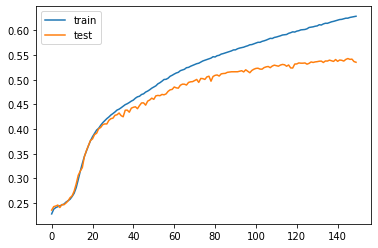

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()